In [ ]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [13]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 231922417


In [ ]:
# define the plotting parameters

figsize = (8,4)

In [15]:
# import the data

# choose a TIC ID to analyze
ticid = 231922417  # EA, only 1 sectors of 2min data, 6 sectors of QLP

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['QLP', 'SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lc_tess = sr.download_all().stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 05,2018,QLP,1800,231922417,0.0,N/A
1,TESS Sector 06,2018,QLP,1800,231922417,0.0,N/A
2,TESS Sector 07,2019,QLP,1800,231922417,0.0,N/A
3,TESS Sector 32,2020,QLP,600,231922417,0.0,N/A
4,TESS Sector 33,2020,QLP,600,231922417,0.0,N/A
5,TESS Sector 34,2021,QLP,600,231922417,0.0,N/A


13808

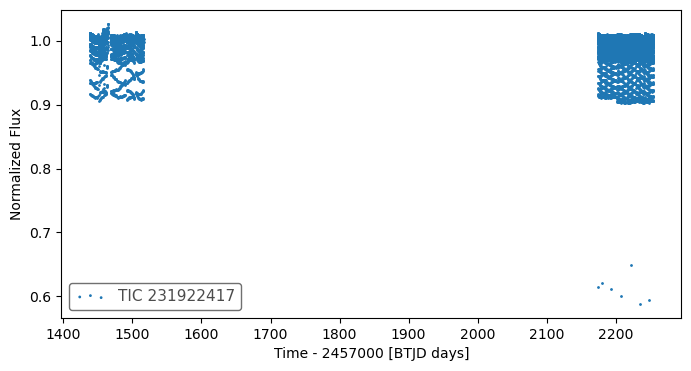

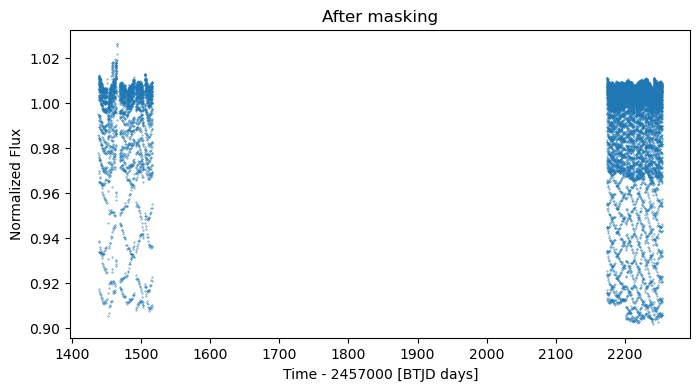

In [20]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

# mask = time < 0 #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

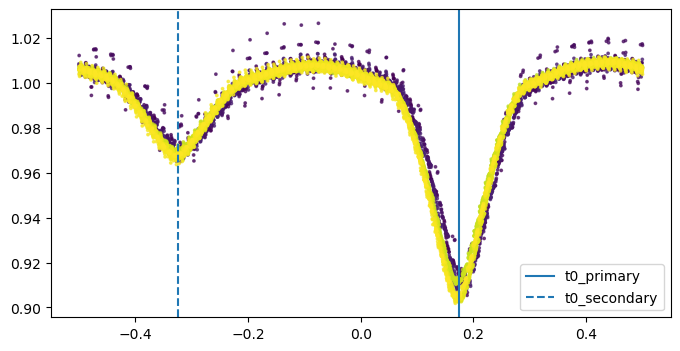

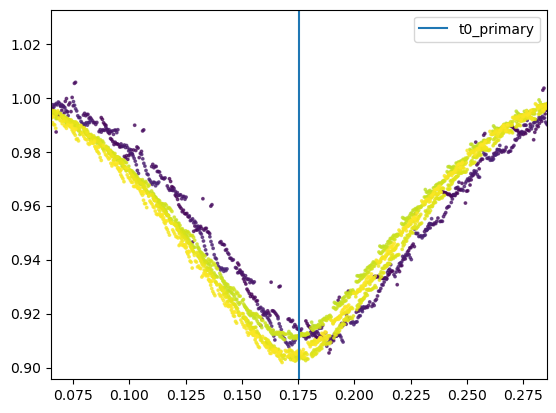

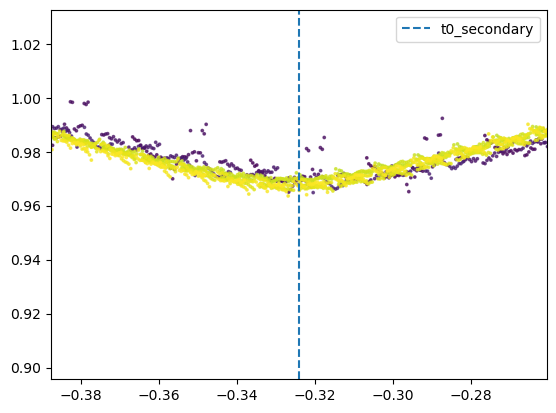

In [32]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# epoch=1438.3228, duration_hr=3.0296, period=0.687452, label="s0005-s0005:TCE1",  # deep, (depth ~10%)
# epoch=1438.6668, duration_hr=1.7502, period=0.687356, label="s0005-s0005:TCE2",  # shallow (depth ~3%)

# FILL-IN THE eclipse epoch / period, 
period = 0.687161 # VSX : 0.687161  #TCE1: 0.687452  # AoV on data_primary (bins 20): 0.687154 ; VSX / AoV result looks close visually

t0_primary = 1438.3228
t0_secondary = 1438.6668


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 3.0296
duration_hr_secondary = 1.7502

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.35  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

### Now that the data is ready we can start 

In [33]:
# show data to visualize what's changed in each step below
data  

,time,flux,err,phase
0,1437.991649,0.977723,0.010587,-0.306698
1,1438.012483,0.986003,0.010587,-0.276379
2,1438.033317,0.995307,0.010587,-0.246060
3,1438.054151,1.003467,0.010587,-0.215742
4,1438.074985,1.007332,0.010587,-0.185423
...,...,...,...,...
13796,2254.032920,0.976113,0.012291,0.247996
13797,2254.039864,0.983881,0.012291,0.258101
13798,2254.046808,0.989987,0.012291,0.268207
13799,2254.053753,0.995274,0.012291,0.278313


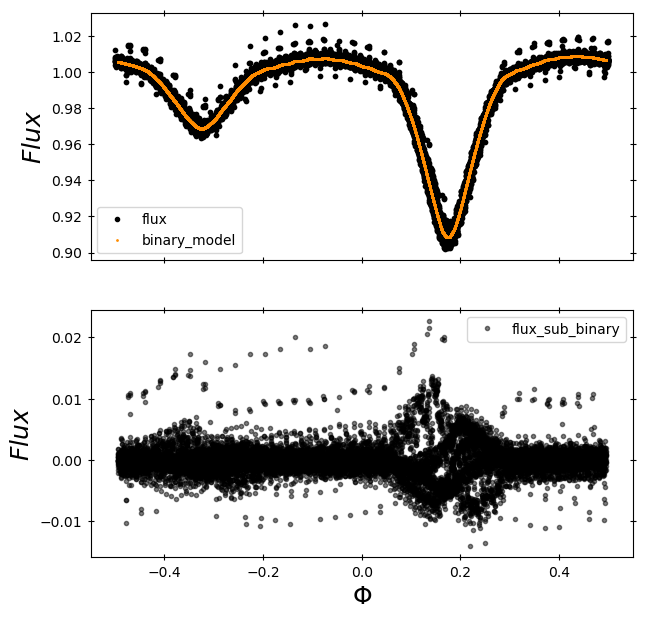

,time,flux,err,phase,flux_sub_binary,binary_model
0,1437.991649,0.977723,0.010587,-0.306698,0.006221,0.971502
1,1438.012483,0.986003,0.010587,-0.276379,0.004696,0.981306
2,1438.033317,0.995307,0.010587,-0.246060,0.003813,0.991494
3,1438.054151,1.003467,0.010587,-0.215742,0.004322,0.999145
4,1438.074985,1.007332,0.010587,-0.185423,0.005191,1.002141
...,...,...,...,...,...,...
13796,2254.032920,0.976113,0.012291,0.247996,0.002754,0.973359
13797,2254.039864,0.983881,0.012291,0.258101,0.002328,0.981553
13798,2254.046808,0.989987,0.012291,0.268207,0.001966,0.988021
13799,2254.053753,0.995274,0.012291,0.278313,0.001995,0.993279


In [62]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 13662 901
reached the end
10 12181 901
reached the end
10 11778 901
reached the end
10 11666 901
reached the end
10 11637 901
reached the end


,time,flux,err,phase,flux_sub_binary,binary_model,flux_detrended
0,1437.991649,0.977723,0.010587,-0.306698,0.006221,0.971502,0.972907
1,1438.012483,0.986003,0.010587,-0.276379,0.004696,0.981306,0.981200
2,1438.033317,0.995307,0.010587,-0.246060,0.003813,0.991494,0.990518
3,1438.054151,1.003467,0.010587,-0.215742,0.004322,0.999145,0.998694
4,1438.074985,1.007332,0.010587,-0.185423,0.005191,1.002141,1.002575
...,...,...,...,...,...,...,...
13796,2254.032920,0.976113,0.012291,0.247996,0.002754,0.973359,0.973751
13797,2254.039864,0.983881,0.012291,0.258101,0.002328,0.981553,0.981501
13798,2254.046808,0.989987,0.012291,0.268207,0.001966,0.988021,0.987589
13799,2254.053753,0.995274,0.012291,0.278313,0.001995,0.993279,0.992857


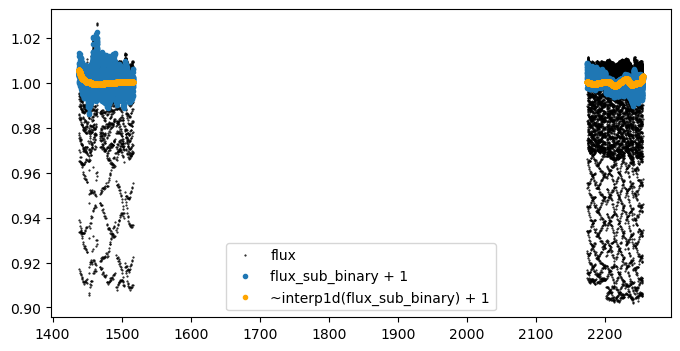

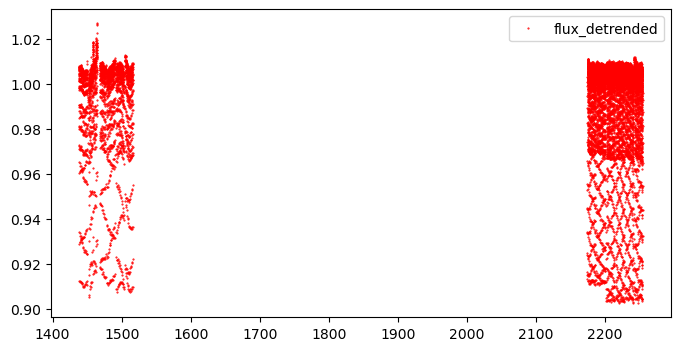

In [63]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

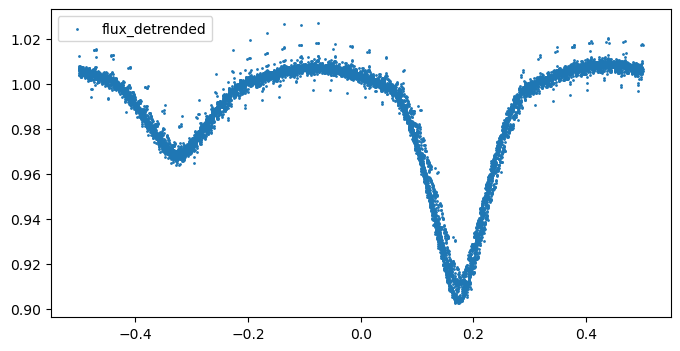

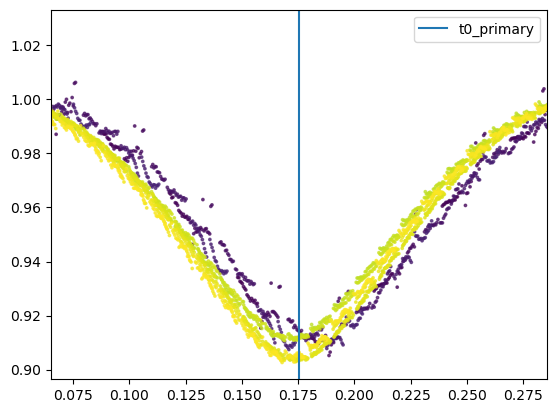

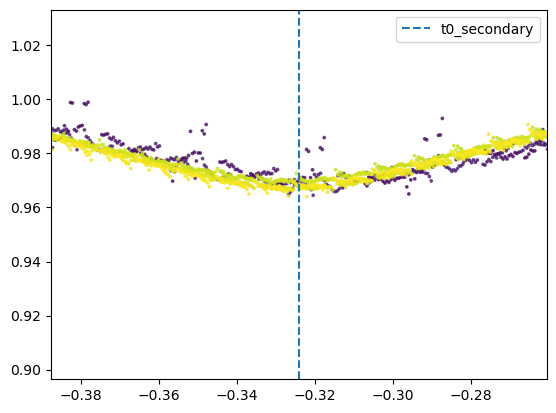

In [64]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

Primary:   1438.3228 0.1752136689946283
window_width_p (phase): 0.1653324330106045
Secondary: 1438.6668 -0.3241758481635763
window_width_s (phase): 0.0955125509160153


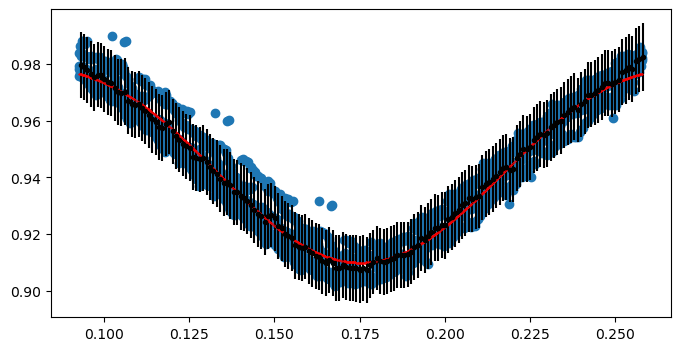

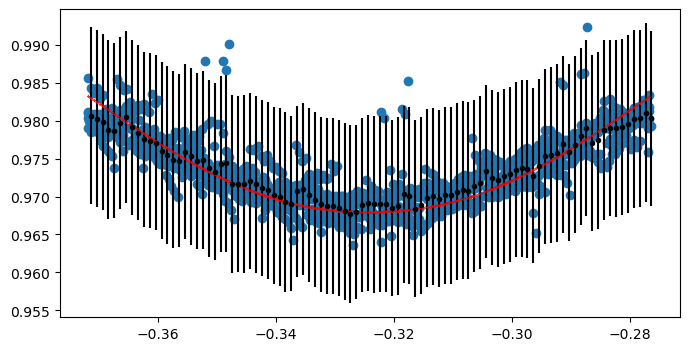

In [55]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.9 * duration_hr_primary / 24 / period
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)
    
    window_width_s = 0.9 * duration_hr_secondary / 24 / period
    # window_width_s = window_width_p
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [0.98, -0.07, midpoint_p, 0.04, 1.0]
start_vals_s = [1.0, -0.032, midpoint_s, 0.042, 1.1]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
if t0_secondary is not None:
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

In [56]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

100%|██████████████████████████████████████████████████████████| 1000/1000 [02:40<00:00,  6.23it/s]


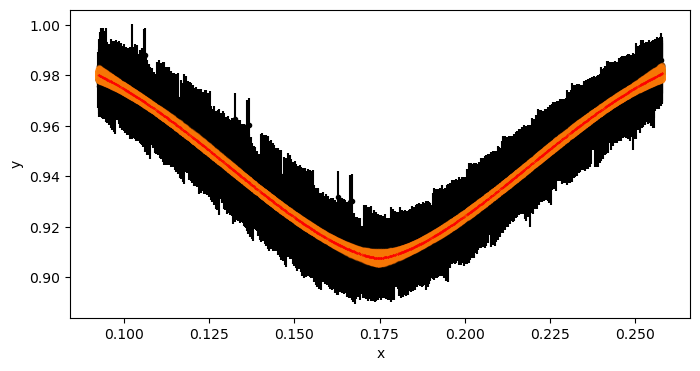

 10%|█████▉                                                      | 98/1000 [00:14<02:07,  7.10it/s]C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in cosh
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.04it/s]


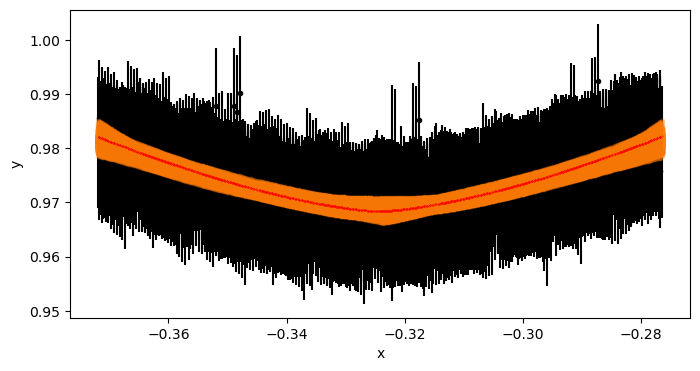

In [57]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [59]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9944211489149896, -0.08676829764647387, 0.1747333946255183, 0.05163183892049694, 0.7626594048363082
    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])

    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 3.9030814013289588, -2.934717038816683, -0.32430652432935514, 1.252576358369491, 0.7416916948616121
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [60]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9944211489149896, -0.08676829764647387, 0.1747333946255183, 0.05163183892049694, 0.7626594048363082
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 3.9030814013289588, -2.934717038816683, -0.32430652432935514, 1.252576358369491, 0.7416916948616121


1187

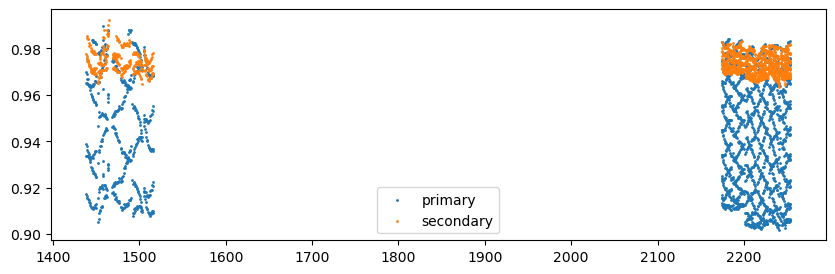

In [61]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1438.3228 0.687161 1438.3228


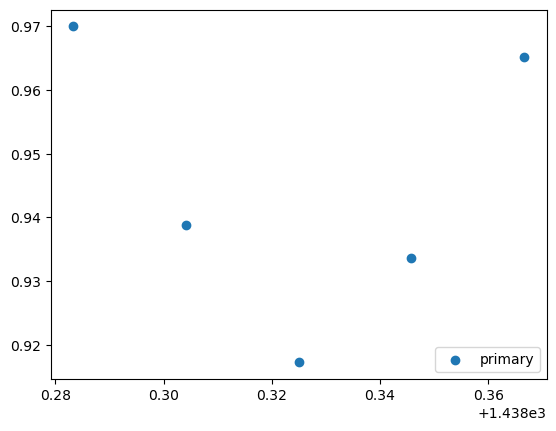

1438.3228 0.687161 1439.009961


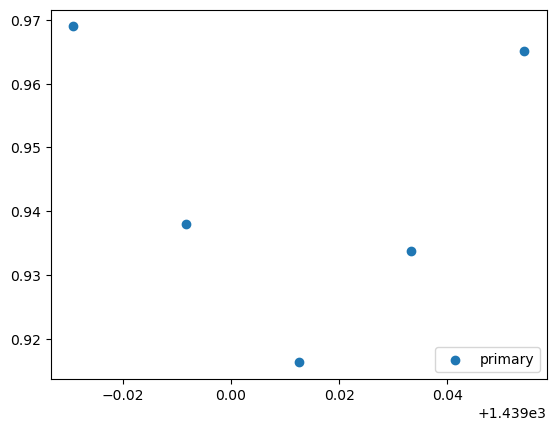

1438.3228 0.687161 1439.6971219999998


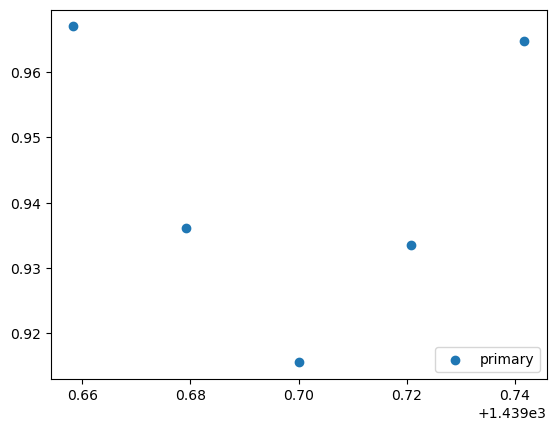

1438.6668 0.687161 1438.6668


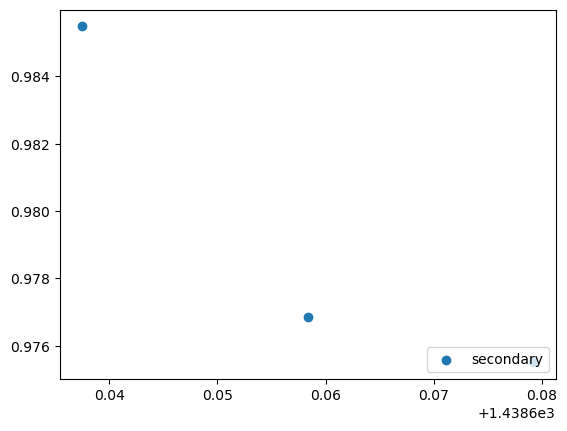

1438.6668 0.687161 1439.353961


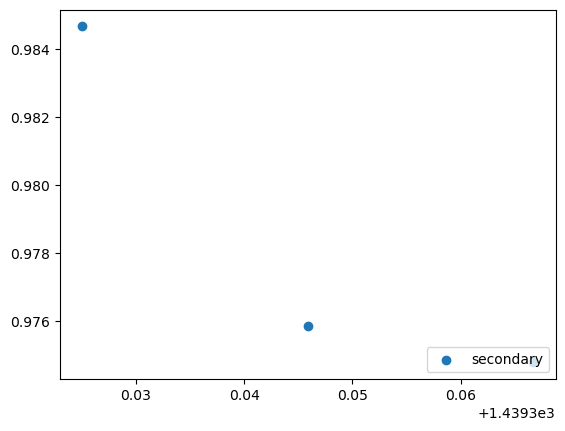

1438.6668 0.687161 1440.0411219999999


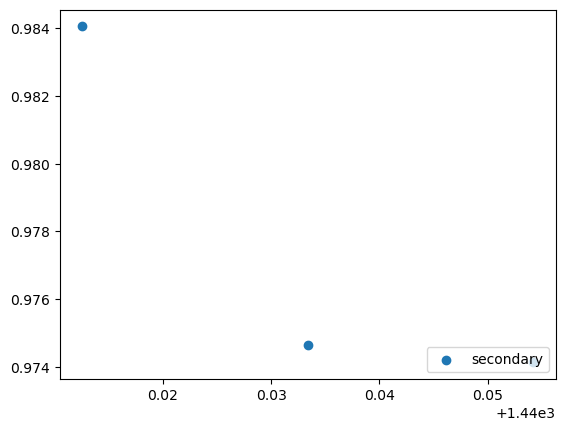

In [65]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
1440.3842829999999 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.71it/s]


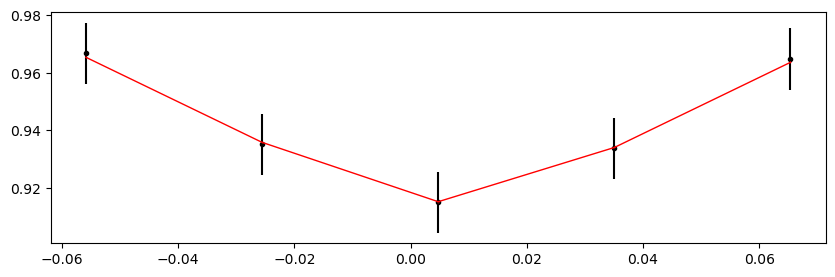

Time 1441.071444 does not have enough data points: 4
1441.758605 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.54it/s]


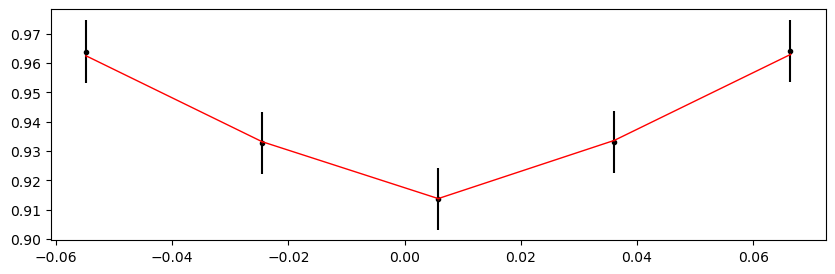

1442.4457659999998 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.90it/s]


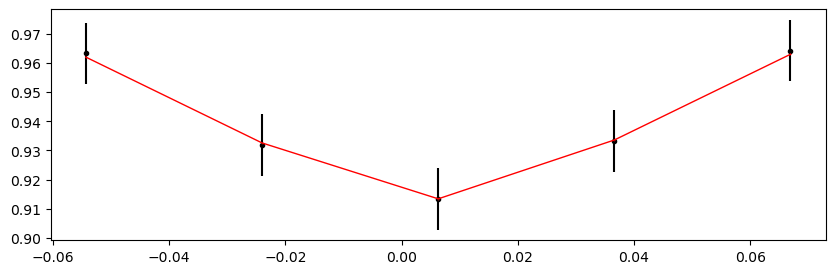

1443.1329269999999 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.15it/s]


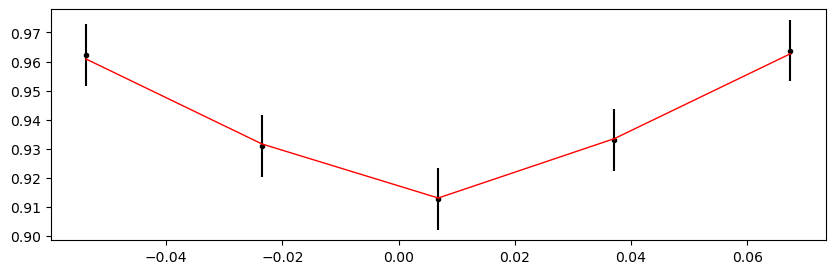

1443.820088 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.80it/s]


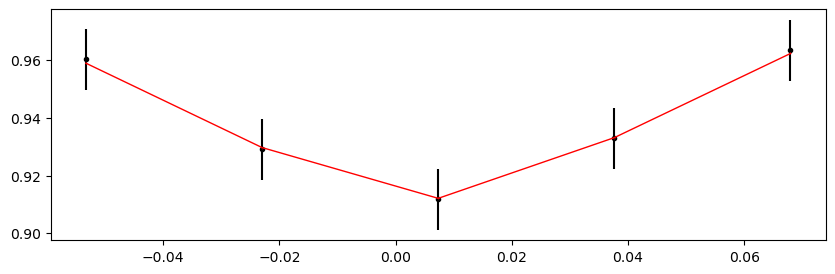

1444.507249 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.59it/s]


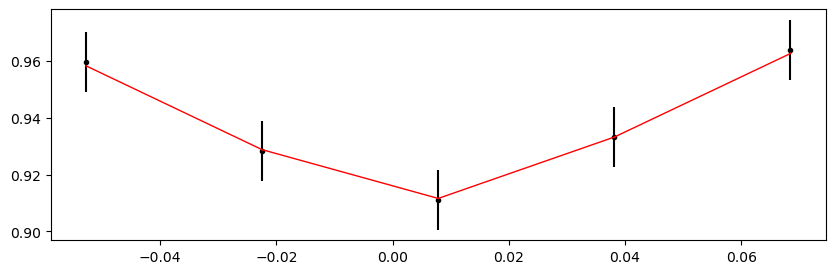

1445.1944099999998 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 434.89it/s]


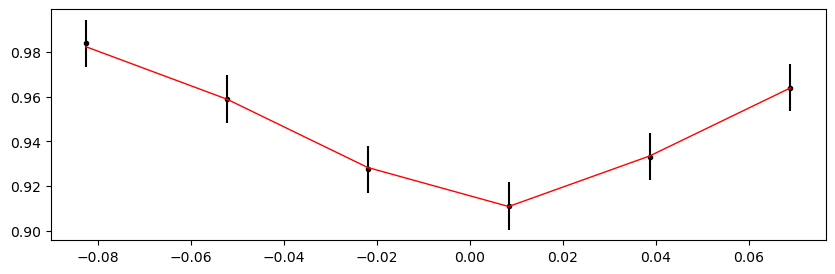

1445.881571 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.40it/s]


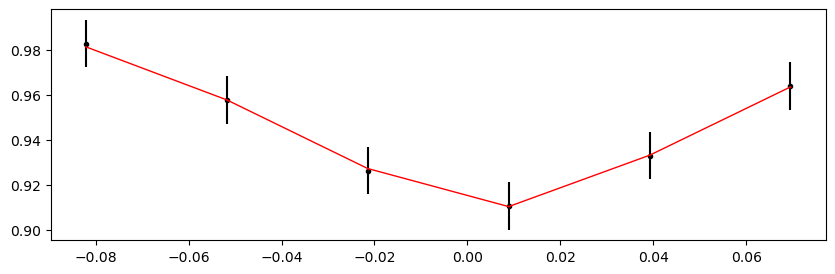

1446.568732 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.65it/s]


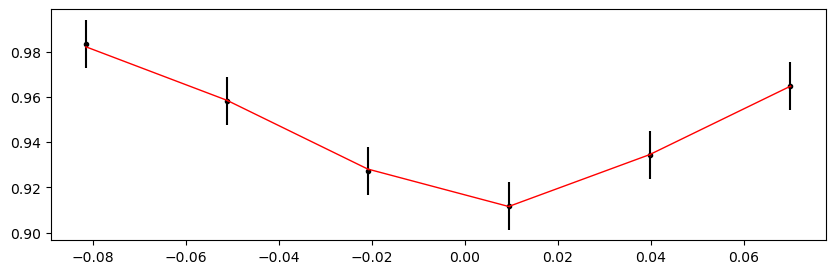

1447.255893 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.56it/s]


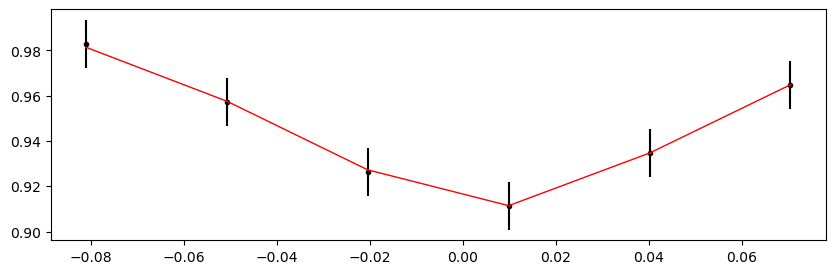

1447.9430539999998 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.69it/s]


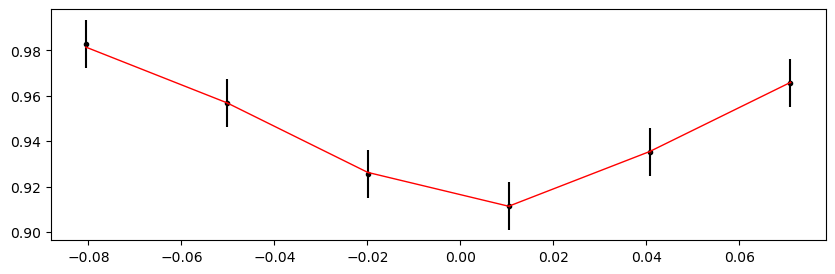

1448.630215 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.54it/s]


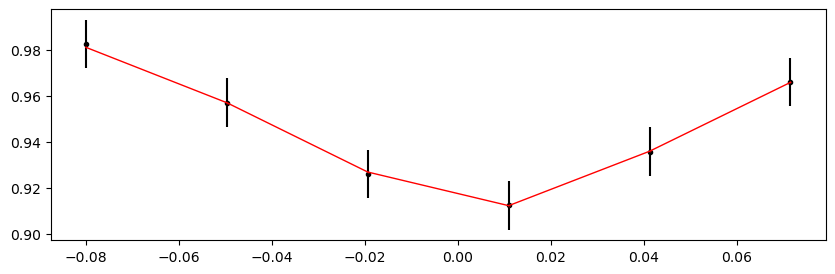

1449.317376 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.61it/s]


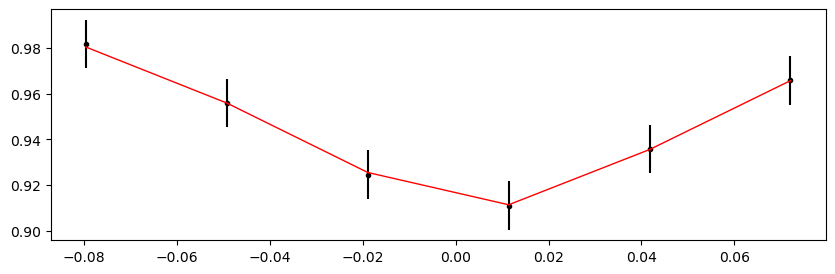

1450.004537 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.51it/s]


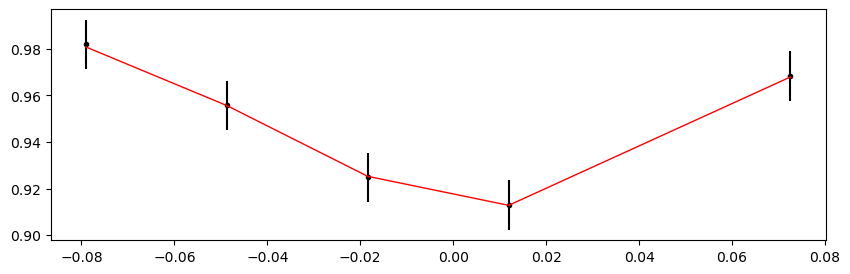

1452.06602 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.95it/s]


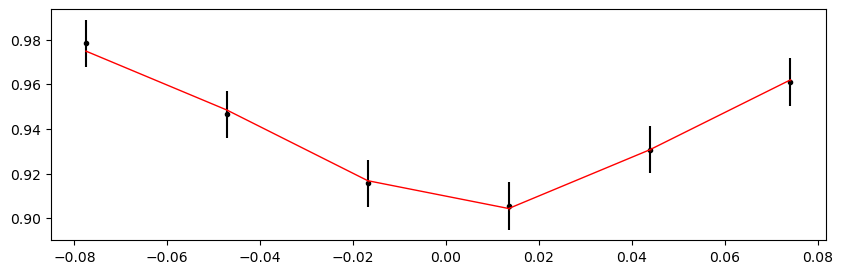

1452.7531809999998 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.49it/s]


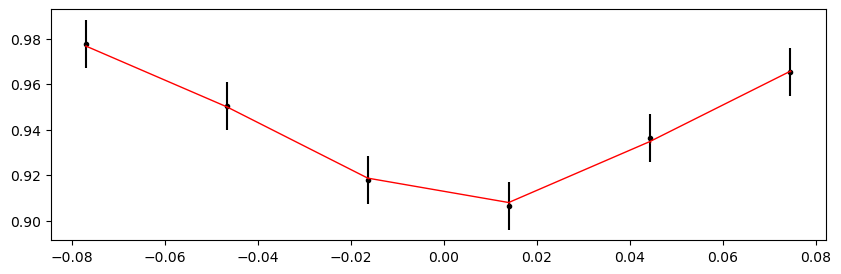

1453.4403419999999 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.62it/s]


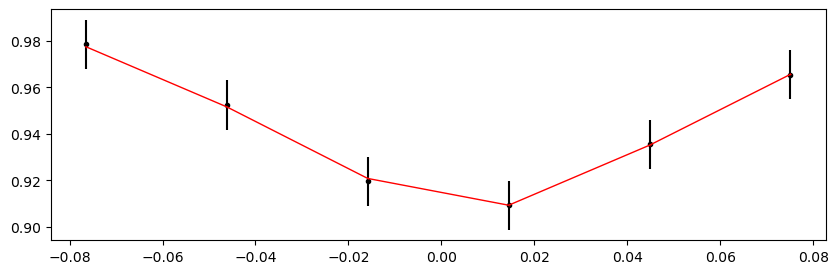

1454.127503 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.32it/s]


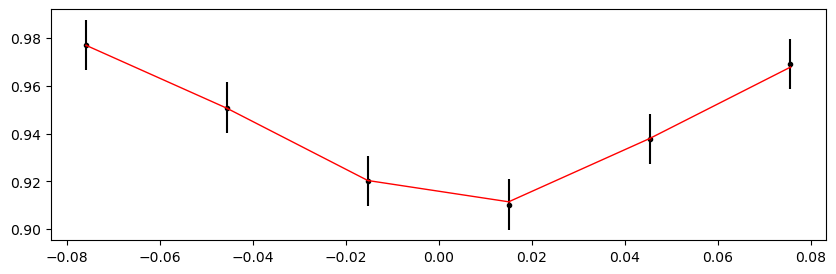

1454.814664 0.9944211489149896 -0.08676829764647387 0.1747333946255183


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.31it/s]


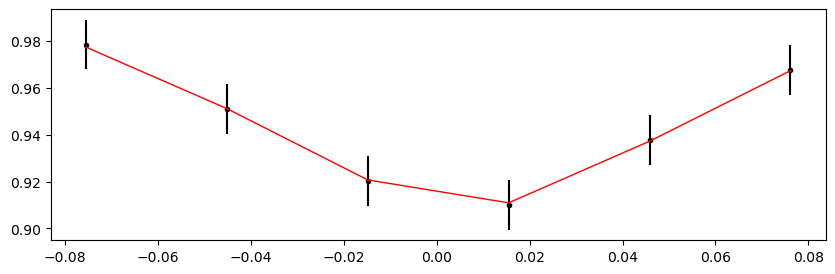

1455.5018249999998 0.9944211489149896 -0.08676829764647387 0.1747333946255183


 92%|███████████████████████████████████████████████████▋    | 9230/10000 [00:21<00:01, 394.30it/s]

In [ ]:
%matplotlib inline

from importlib import reload
reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=4, 
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"



Fitting individual secondary eclipses...
Creating new manifest file
Time 1438.6668 does not have enough data points: 3
Time 1439.353961 does not have enough data points: 3
Time 1440.0411219999999 does not have enough data points: 3
Time 1440.728283 does not have enough data points: 3
Time 1441.415444 does not have enough data points: 3
Time 1442.102605 does not have enough data points: 3
Time 1442.7897659999999 does not have enough data points: 3
Time 1443.476927 does not have enough data points: 3
Time 1444.164088 does not have enough data points: 3
Time 1444.851249 does not have enough data points: 3
Time 1445.5384099999999 does not have enough data points: 3
Time 1446.225571 does not have enough data points: 3
Time 1446.912732 does not have enough data points: 3
Time 1447.599893 does not have enough data points: 3
Time 1448.287054 does not have enough data points: 3
Time 1448.974215 does not have enough data points: 3
Time 1449.661376 does not have enough data points: 3
Time 1451.72

  0%|                                                                    | 0/10000 [00:00<?, ?it/s]C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.70it/s]


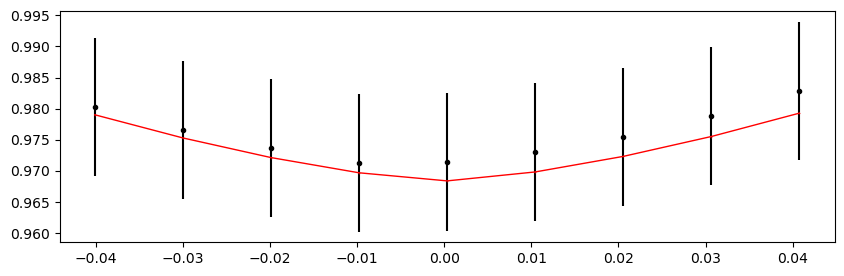

2175.303392 3.9030814013289588 -2.934717038816683 -0.32430652432935514


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1319.89it/s]


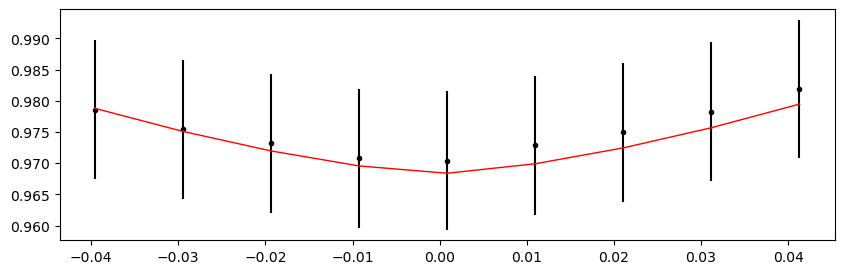

2175.990553 3.9030814013289588 -2.934717038816683 -0.32430652432935514


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1294.62it/s]


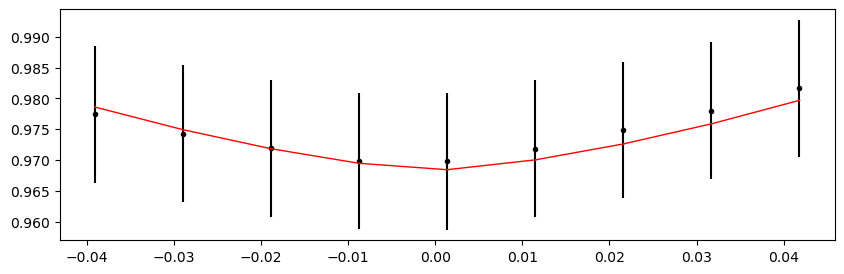

2176.677714 3.9030814013289588 -2.934717038816683 -0.32430652432935514


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1331.56it/s]


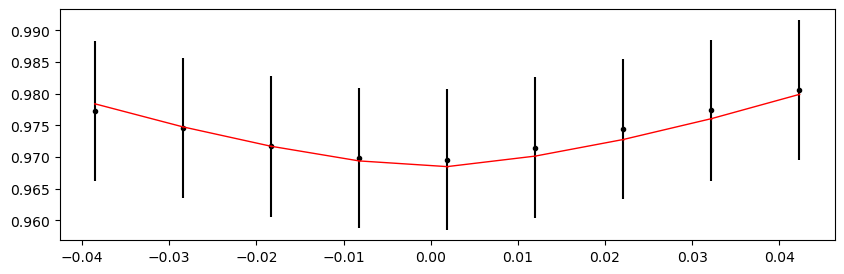

2177.364875 3.9030814013289588 -2.934717038816683 -0.32430652432935514


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.61it/s]


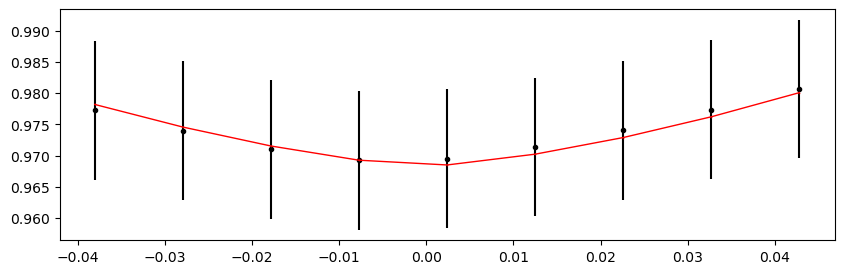

2178.052036 3.9030814013289588 -2.934717038816683 -0.32430652432935514


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1328.28it/s]


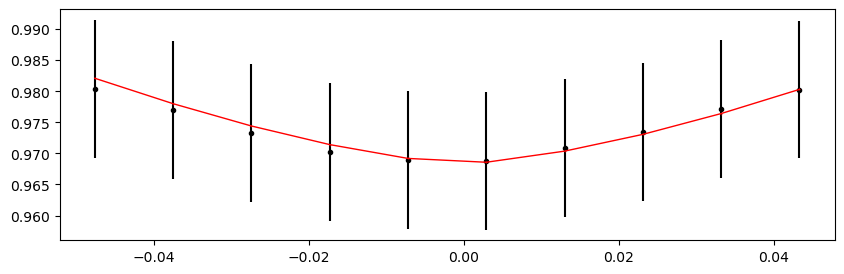

2178.739197 3.9030814013289588 -2.934717038816683 -0.32430652432935514


 16%|████████▊                                              | 1605/10000 [00:01<00:06, 1337.47it/s]


KeyboardInterrupt: 

In [68]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=4, 
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

In [ ]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              lw = 1, color = 'crimson', )
axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
# axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
#              lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    # axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
    #              lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, transit timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot, Zoom In

In [ ]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1300, 1450),
    (2000, 2200),
    (3100, 3250),
]
title_suffix = "transit timing variation"

def tweak_axs_list(axs_list):
    ax = axs_list[0][1]
    # ax.set_title(f"{ax.get_title()}, Sectors 1-3")
    # ax.set_ylim(None, 18);
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

In [ ]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1000)
plt.show()


## Results Summary

In [ ]:
# FILL-IN the ETV results / comments
has_etv = "Y?"
comments = "Possibly ETV. Another possibility is the period not precise enough."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))